# Week 6 Assignment

This week's assignment will be combining many of the concepts from weeks 5 and 6. Below, I've loaded the immunization dataset from week 5, minimally handled NaNs, separated continuous and categorical columns (somewhat harder to do than expected), and built a baseline RandomForestClassifier with a random column, as in week 5. My target column was FRSTBRN -- not a very interesting column, but it had no missing values... 

Your job is to use visualization to find important features, drop irrelevant features, and generally improve the classification.

**Note:** Be mindful when doing pair plots, correlation matrices, heatmaps, etc. The sheer number of columns will overwhelm your computer. ONLY do subsets of columns with these functions!

Pay special attention to:

* Handling NaN values
    * Determine which columns to keep & which to drop. 
        * For example: All data is from 2014, so the "YEAR" column might not be adding much to the analysis.
* Pair plots, heatmaps, facet grids, etc.
    * Choose plots from any 2 of the 3 charting libraries presented in the FTE.
* Documentation -- 
    * What do the pretty pictures **mean**? 
    * How does this help you decide what features are important?

*** 

Altair gallery: https://altair-viz.github.io/gallery/ <br>
Seaborn gallery: https://seaborn.pydata.org/examples/index.html <br>
Matplotlib gallery: https://matplotlib.org/3.1.1/gallery/index.html <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

In [2]:
# now we won't need to use plt.show() throguhtout this notebook
%matplotlib inline

In [3]:
# setting the aesthetics for seaborn
sns.set()

In [4]:
df = pd.read_csv("data_6/nispuf14.csv", na_values=['.'], low_memory=False)

In [5]:
df.head()

,SEQNUMC,SEQNUMHH,PDAT,PROVWT_D,PROVWT_D_TERR,RDDWT_D,RDDWT_D_TERR,STRATUM,YEAR,AGECPOXR,...,XVRCTY7,XVRCTY8,XVRCTY9,INS_1,INS_2,INS_3,INS_3A,INS_4_5,INS_6,INS_11
0,11,1,2,.,.,218.30024855484000,218.300249,1022,2014,NaN,...,,,,.,.,.,.,.,.,.
1,21,2,1,806.84601169505000,806.84601169505000,454.86041741251200,454.860417,2036,2014,NaN,...,,,,2,.,.,2,2,2,.
2,31,3,2,.,.,30.54542540283290,30.545425,1072,2014,NaN,...,,,,.,.,.,.,.,.,.
3,41,4,1,63.44868567610260,63.44868567610260,36.96593137368630,36.965931,2016,2014,NaN,...,,,,1,2,2,.,2,2,2
4,51,5,1,94.87263225744540,94.87263225744540,64.62020426239790,64.620204,1073,2014,NaN,...,,,,2,1,1,.,2,2,77


In [6]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [7]:
df.head()

,SEQNUMC,SEQNUMHH,PDAT,PROVWT_D,PROVWT_D_TERR,RDDWT_D,RDDWT_D_TERR,STRATUM,YEAR,AGECPOXR,...,XVRCTY7,XVRCTY8,XVRCTY9,INS_1,INS_2,INS_3,INS_3A,INS_4_5,INS_6,INS_11
0,11,1,2,NaN,NaN,218.300249,218.300249,1022,2014,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21,2,1,806.846012,806.846012,454.860417,454.860417,2036,2014,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,2.0,2.0,2.0,NaN
2,31,3,2,NaN,NaN,30.545425,30.545425,1072,2014,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,41,4,1,63.448686,63.448686,36.965931,36.965931,2016,2014,NaN,...,NaN,NaN,NaN,1.0,2.0,2.0,NaN,2.0,2.0,2.0
4,51,5,1,94.872632,94.872632,64.620204,64.620204,1073,2014,NaN,...,NaN,NaN,NaN,2.0,1.0,1.0,NaN,2.0,2.0,77.0


<div class="alert alert-block alert-info">
<b>Pop Quiz::</b> Why are we making a copy of the df at this point and not just using the original?
</div>

In [8]:
df_copy = df.copy()

In [9]:
from PyPDF2 import PdfFileReader
from PyPDF2.pdf import Destination  # read the pdf file

In [10]:
pdf_file = 'data_6/NISPUF14_CODEBOOK.PDF'

In [11]:
reader = PdfFileReader(pdf_file)
outlines = reader.outlines

I notice the PDF's outline tells us which variables are continuous. I would like to be able to read that outline and get those variables. Unfortunately, the PDF outline format is not terribly conducive to this operation.

<img src="figures_6/pdf_continuous.png" width=800><br>

As you can see, in the outlne "tree", when we see the text "Continuous Statistics", we need the **previous** entry, but PDF outlines are weird mixes of dictionaries and lists. I finally found the following answer on StackOverflow that satisfied the need. 

From https://stackoverflow.com/questions/1011938/python-previous-and-next-values-inside-a-loop

In [12]:
from itertools import tee, islice, chain

def previous_and_next(some_iterable):
    prevs, items, nexts = tee(some_iterable, 3)
    prevs = chain([None], prevs)
    nexts = chain(islice(nexts, 1, None), [None])
    return zip(prevs, items, nexts)

Testing if I could find the word "Contnuous" in the PDF outline.

In [13]:
'Continuous' in outlines[7][0].title

True

In [14]:
cont_list = []
for prev, item, nxt in previous_and_next(outlines):
    if isinstance(item, list) :
        if 'Continuous' in str(item[0].title):
            cont_list.append(prev.title)

In [15]:
cont_list[:5]

['PROVWT_D', 'PROVWT_D_TERR', 'RDDWT_D', 'RDDWT_D_TERR', 'BF_ENDR06']

In [16]:
cat_list = [c for c in df_copy.columns if c not in cont_list]

#### Cleaning up the missing values
For categories, fill with -999 <br>
For continuous, fill with mean.

```
If your columns are a string then use :
df[ ' string column name' ].fillna(-999, inplace = True)

If your columns are not a string then use :
df[ ' column name ' ].fillna(df[ ' column name ' ].mean() , inplace = True)
```

In [17]:
for col in cat_list:
    df_copy[col].fillna(-999, inplace=True)

In [18]:
for col in cont_list:
    df_copy[col].fillna(df[col].mean(), inplace=True)

In [19]:
df_copy.head()

,SEQNUMC,SEQNUMHH,PDAT,PROVWT_D,PROVWT_D_TERR,RDDWT_D,RDDWT_D_TERR,STRATUM,YEAR,AGECPOXR,...,XVRCTY7,XVRCTY8,XVRCTY9,INS_1,INS_2,INS_3,INS_3A,INS_4_5,INS_6,INS_11
0,11,1,2,383.438950,382.821312,218.300249,218.300249,1022,2014,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,21,2,1,806.846012,806.846012,454.860417,454.860417,2036,2014,-999.0,...,-999.0,-999.0,-999.0,2.0,-999.0,-999.0,2.0,2.0,2.0,-999.0
2,31,3,2,383.438950,382.821312,30.545425,30.545425,1072,2014,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,41,4,1,63.448686,63.448686,36.965931,36.965931,2016,2014,-999.0,...,-999.0,-999.0,-999.0,1.0,2.0,2.0,-999.0,2.0,2.0,2.0
4,51,5,1,94.872632,94.872632,64.620204,64.620204,1073,2014,-999.0,...,-999.0,-999.0,-999.0,2.0,1.0,1.0,-999.0,2.0,2.0,77.0


## Random Forest Classifier Benchmark

My target is going to be FRSTBRN -- FIRST BORN STATUS OF CHILD.

1 - No<br>
2 - Yes



In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

<div class="alert alert-block alert-info">
<b>Pop Quiz::</b> Do you know what the following does? 
</div>

In [21]:
np.random.seed(42)

In [22]:
y = df_copy['FRSTBRN']
X = df_copy.drop('FRSTBRN', axis=1)

I'm going to get the min and max values from one of the continuous variables to use as the min/max for the random column. 

In [23]:
the_min = X.PROVWT_D.min()
the_max = X.PROVWT_D.max()
X['random'] = np.random.normal(the_min, the_max, size=X.shape[0])

In [24]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [25]:
clf=RandomForestClassifier(n_estimators=100)

In [26]:
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [27]:
y_pred=clf.predict(x_test)

In [28]:
from sklearn import metrics

In [29]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 

Accuracy: 0.8832663989290496


#### Feature Importance

In [30]:
features = x_train.columns
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


feature_rank = []
# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    feature = f"{f + 1}. feature {features[indices[f]]}   \t{importances[indices[f]] * 100 :.2f}%"
    if 'random' in features[indices[f]]:
        feature += " <=="
    print(feature)
    feature_rank.append([features[indices[f]], importances[indices[f]]] )



Feature ranking:
1. feature CHILDNM   	27.04%
2. feature C1R   	15.07%
3. feature random   	1.72% <==
4. feature SEQNUMC   	1.61%
5. feature RDDWT_D_TERR   	1.59%
6. feature SEQNUMHH   	1.58%
7. feature RDDWT_D   	1.53%
8. feature STRATUM   	1.46%
9. feature INCPORAR   	1.41%
10. feature M_AGEGRP   	1.32%
11. feature BF_ENDR06   	1.27%
12. feature EST_GRANT   	1.27%
13. feature ESTIAP14   	1.24%
14. feature STATE   	1.18%
15. feature BF_FORMR08   	1.06%
16. feature INCQ298A   	1.02%
17. feature BF_EXCLR06   	0.99%
18. feature NUM_CELLS_HH   	0.74%
19. feature AGEGRP   	0.70%
20. feature EDUC1   	0.66%
21. feature D6R   	0.61%
22. feature PROVWT_D   	0.60%
23. feature PROVWT_D_TERR   	0.58%
24. feature INCPOV1   	0.58%
25. feature C5R   	0.56%
26. feature DDTP4   	0.51%
27. feature CEN_REG   	0.51%
28. feature INTRP   	0.50%
29. feature DVRC1   	0.49%
30. feature NUM_CELLS_PARENTS   	0.49%
31. feature DHEPB2   	0.48%
32. feature DHIB3   	0.48%
33. feature DDTP3   	0.48%
34. feature DFLU

Hmmm... Our random number turns out to be the third most important feature for my target variable of FRSTBRN.  That's kindda sad! Lesson of the day, choose your variables wisely.

## Week 6 Deliverable:

* Choose your own categorical variable (or one of the continuous ones if you feel brave).
* Do a correlation matrix to find variable relationships that have a high probability of correlation.
* Reduce the dataset to only include correlated variables from above.
* Complete EDA using the FTE as a baseline -- feel free to add your own tests.
    * Choose plots from any 2 of the 3 charting libraries presented in the FTE.
    * Or substitute a library of your own if you have experience with something else.
* Based on EDA results, either
    * Go back for more variables, or
    * Drop more variables
* Do some machine learning algorithm against your target variable
    * RandomForestClassifier (lke the FTE and above) if you haven't had experience with Machine Learning yet, or
    * Choose your favorite algorithm based on variable type
* Summary of your findings. For example, my FRSTBRN investigation shows the top 2 variables for determining whether a child is firstborn are:
    * CHILDNM -- Number of children in the household, and
    * C1R  -- Number of people in the household.
    

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
from PyPDF2 import PdfFileReader
from PyPDF2.pdf import Destination  # read the pdf file

In [226]:
# now we won't need to use plt.show() throguhtout this notebook
%matplotlib inline

In [227]:
# setting the aesthetics for seaborn
sns.set()

In [228]:
df = pd.read_csv("C:/Users/eltac/Downloads/data_6/data_6/nispuf14.csv", na_values=['.'], low_memory=False)

In [229]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [256]:
df_copy = df.copy()

In [231]:
pdf_file = 'C:/Users/eltac/Downloads/data_6/data_6/NISPUF14_CODEBOOK.PDF'

In [232]:
reader = PdfFileReader(pdf_file)
outlines = reader.outlines

In [233]:
from itertools import tee, islice, chain

def previous_and_next(some_iterable):
    prevs, items, nexts = tee(some_iterable, 3)
    prevs = chain([None], prevs)
    nexts = chain(islice(nexts, 1, None), [None])
    return zip(prevs, items, nexts)

In [234]:
'Continuous' in outlines[7][0].title

True

In [235]:
cont_list = []
for prev, item, nxt in previous_and_next(outlines):
    if isinstance(item, list) :
        if 'Continuous' in str(item[0].title):
            cont_list.append(prev.title)

In [236]:
cont_list[:5]

['PROVWT_D', 'PROVWT_D_TERR', 'RDDWT_D', 'RDDWT_D_TERR', 'BF_ENDR06']

In [237]:
cat_list = [c for c in df_copy.columns if c not in cont_list]

In [238]:
for col in cat_list:
    df_copy[col].fillna('NA', inplace=True)

In [239]:
for col in cont_list:
    df_copy[col].fillna(df[col].mean(), inplace=True)

In [255]:
df_copy.head()

,SEQNUMC,SEQNUMHH,PDAT,PROVWT_D,PROVWT_D_TERR,RDDWT_D,RDDWT_D_TERR,STRATUM,YEAR,AGECPOXR,...,XVRCTY7,XVRCTY8,XVRCTY9,INS_1,INS_2,INS_3,INS_3A,INS_4_5,INS_6,INS_11
0,11,1,2,383.438950,382.821312,218.300249,218.300249,1022,2014,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,21,2,1,806.846012,806.846012,454.860417,454.860417,2036,2014,NA,...,NA,NA,NA,2,NA,NA,2,2,2,NA
2,31,3,2,383.438950,382.821312,30.545425,30.545425,1072,2014,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,41,4,1,63.448686,63.448686,36.965931,36.965931,2016,2014,NA,...,NA,NA,NA,1,2,2,NA,2,2,2
4,51,5,1,94.872632,94.872632,64.620204,64.620204,1073,2014,NA,...,NA,NA,NA,2,1,1,NA,2,2,77


In [247]:
corrmat = df_copy.corr()
#corrmat.fillna(-999,inplace=True)

In [248]:
corrmat

,SEQNUMC,SEQNUMHH,PDAT,PROVWT_D,PROVWT_D_TERR,RDDWT_D,RDDWT_D_TERR,STRATUM,YEAR,HAD_CPOX,...,POL6_AGE,RB1_AGE,ROT1_AGE,ROT2_AGE,ROT3_AGE,ROT4_AGE,ROT5_AGE,VRC1_AGE,VRC2_AGE,VRC3_AGE
SEQNUMC,1.000000,1.000000,-7.604832e-03,5.486064e-03,5.595945e-03,0.011525,0.011311,0.002699,NaN,1.068699e-02,...,1.733404e-03,NaN,-2.333379e-03,3.245558e-03,-4.287170e-03,1.136554e-03,NaN,-6.372265e-03,5.782464e-03,0.004140
SEQNUMHH,1.000000,1.000000,-7.604911e-03,5.486067e-03,5.595947e-03,0.011525,0.011311,0.002699,NaN,1.068698e-02,...,1.733404e-03,NaN,-2.333409e-03,3.245542e-03,-4.287165e-03,1.136574e-03,NaN,-6.372276e-03,5.782445e-03,0.004140
PDAT,-0.007605,-0.007605,1.000000e+00,-2.090044e-15,-1.255624e-15,0.017575,0.015001,0.046724,NaN,1.717672e-02,...,-4.594655e-16,NaN,-2.010327e-16,4.720177e-17,6.033702e-17,7.707524e-16,NaN,3.243435e-16,-6.143753e-16,0.000000
PROVWT_D,0.005486,0.005486,-2.090044e-15,1.000000e+00,9.991748e-01,0.717055,0.716155,0.157993,NaN,-1.722259e-03,...,-8.902104e-04,NaN,1.247691e-02,1.244583e-02,-3.715663e-05,-7.565883e-03,NaN,1.048815e-02,5.387244e-03,-0.002043
PROVWT_D_TERR,0.005596,0.005596,-1.255624e-15,9.991748e-01,1.000000e+00,0.716453,0.716344,0.157841,NaN,-1.698256e-03,...,-8.894758e-04,NaN,1.203198e-02,1.179097e-02,-1.296576e-04,-7.559640e-03,NaN,1.038227e-02,5.546398e-03,-0.002041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ROT4_AGE,0.001137,0.001137,7.707524e-16,-7.565883e-03,-7.559640e-03,-0.006498,-0.006490,-0.001974,NaN,-2.280156e-17,...,-2.154122e-21,NaN,5.182164e-03,5.966599e-03,1.220107e-02,1.000000e+00,NaN,2.318328e-03,1.028521e-22,0.000000
ROT5_AGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VRC1_AGE,-0.006372,-0.006372,3.243435e-16,1.048815e-02,1.038227e-02,0.007370,0.006646,0.000330,NaN,1.878771e-02,...,1.560639e-02,NaN,7.460105e-02,7.659679e-02,3.517114e-02,2.318328e-03,NaN,1.000000e+00,2.498020e-02,0.001988
VRC2_AGE,0.005782,0.005782,-6.143753e-16,5.387244e-03,5.546398e-03,0.002540,0.002731,0.002090,NaN,-1.258516e-02,...,2.478519e-02,NaN,-1.080524e-03,-5.685744e-03,5.619244e-02,1.028521e-22,NaN,2.498020e-02,1.000000e+00,-0.024414


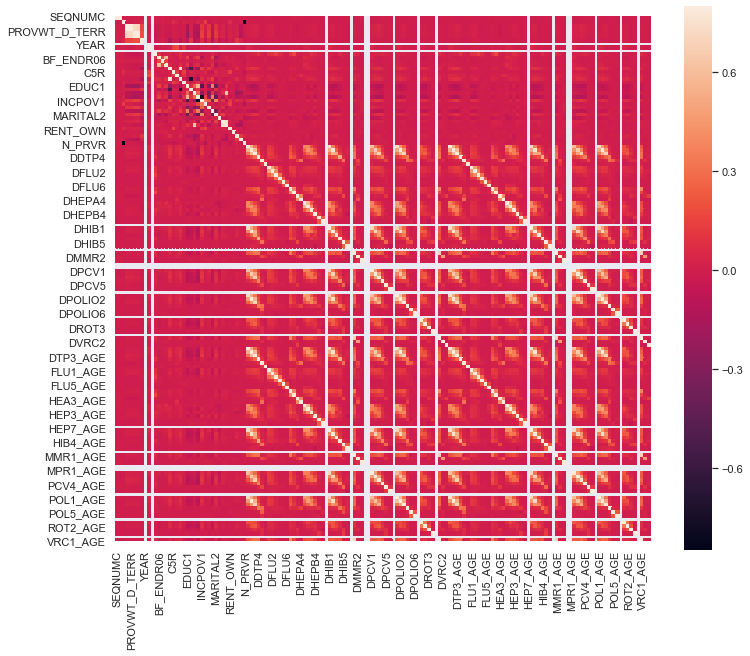

In [334]:
f, ax = plt.subplots(figsize=(12,10)) #setting some parameters of the plot to help readability
sns.heatmap(corrmat, vmax = .8, square=True)

In [250]:
c=corrmat.abs()
s = c.unstack().dropna()

so = s.sort_values(kind="quicksort")

print (so[-4470:-4460])

DFLU3     VRC1_AGE    0.054361
MARITAL2  POL2_AGE    0.054388
POL2_AGE  MARITAL2    0.054388
DPCV6     DHIB6       0.054464
DHIB6     DPCV6       0.054464
DTP5_AGE  HEP4_AGE    0.054495
HEP4_AGE  DTP5_AGE    0.054495
FRSTBRN   PCV3_AGE    0.054710
PCV3_AGE  FRSTBRN     0.054710
HEP5_AGE  DTP4_AGE    0.054824
dtype: float64


In [258]:
df_final=df_copy[['FRSTBRN','PCV3_AGE']]

In [259]:
df_final.head()

,FRSTBRN,PCV3_AGE
0,2,NaN
1,1,6.0
2,1,NaN
3,1,4.0
4,1,13.0


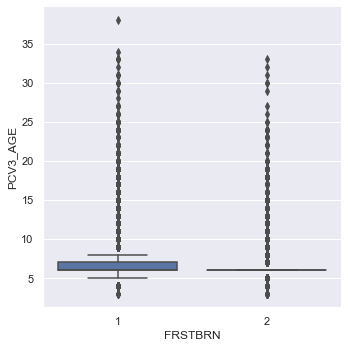

In [265]:
sns.catplot('FRSTBRN', 'PCV3_AGE', data=df_final, kind='box')

In [271]:
piv1 = df_final.pivot_table(index=['FRSTBRN'], values='PCV3_AGE',aggfunc=[np.mean])
piv1

,mean
,PCV3_AGE
FRSTBRN,
1,7.192784
2,6.764037


In [272]:
df_final=df_copy[['FRSTBRN','PCV3_AGE','CEN_REG','SEX']]

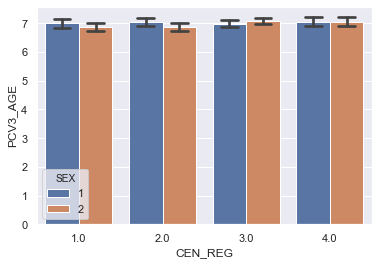

In [275]:
sns.barplot(x='CEN_REG', y='PCV3_AGE',hue='SEX', data=df_final,capsize=.2)

In [276]:
piv2 = df_final.pivot_table(index=['CEN_REG','FRSTBRN','SEX'], values='PCV3_AGE',aggfunc=[np.mean])
piv2

mean
                     PCV3_AGE
CEN_REG FRSTBRN SEX          
1.0     1       1    7.189550
                2    6.891421
        2       1    6.722704
                2    6.850806
2.0     1       1    7.283951
                2    6.913810
        2       1    6.648214
                2    6.807547
3.0     1       1    7.244000
                2    7.258086
        2       1    6.630074
                2    6.820144
4.0     1       1    7.237257
                2    7.169697
        2       1    6.703297
                2    6.844860

In [287]:
df_final.fillna(-999,inplace=True)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [frame.py:4244]


In [288]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [289]:
np.random.seed(78)

In [290]:
y = df_final['CEN_REG']
X = df_final.drop('CEN_REG', axis=1)

In [291]:
the_min = X.PCV3_AGE.min()
the_max = X.PCV3_AGE.max()
X['random'] = np.random.normal(the_min, the_max, size=X.shape[0])

In [292]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [293]:
clf=RandomForestClassifier(n_estimators=100)

In [294]:
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [295]:
y_pred=clf.predict(x_test)

In [296]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 

Accuracy: 0.25890227576974567


In [297]:
features = x_train.columns
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


feature_rank = []
# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    feature = f"{f + 1}. feature {features[indices[f]]}   \t{importances[indices[f]] * 100 :.2f}%"
    if 'random' in features[indices[f]]:
        feature += " <=="
    print(feature)
    feature_rank.append([features[indices[f]], importances[indices[f]]] )



Feature ranking:
1. feature random   	96.10% <==
2. feature PCV3_AGE   	3.40%
3. feature SEX   	0.34%
4. feature FRSTBRN   	0.16%


In [298]:
df_copy.loc[(df_copy.SEX == 1.0),'SEX']='Male'
df_copy.loc[(df_copy.SEX == 2.0),'SEX']='Female'

In [311]:
df_copy.loc[(df_copy.CEN_REG == 1.0),'CEN_REG']='NE'
df_copy.loc[(df_copy.CEN_REG == 2.0),'CEN_REG']='MW'
df_copy.loc[(df_copy.CEN_REG == 3.0),'CEN_REG']='S'
df_copy.loc[(df_copy.CEN_REG == 4.0),'CEN_REG']='W'

In [312]:
Piv2 = df_copy.pivot_table(index=['CEN_REG','SEX'], values='AGECPOXR',aggfunc=[np.mean, max, min])

In [313]:
Piv2

mean      max      min
                AGECPOXR AGECPOXR AGECPOXR
CEN_REG SEX                               
MW      Female  2.250000      4.0      1.0
        Male    2.553191      4.0      1.0
NE      Female  2.727273      4.0      1.0
        Male    2.468750      4.0      1.0
S       Female  2.434783      4.0      1.0
        Male    2.408163      4.0      1.0
W       Female  2.200000      4.0      1.0
        Male    2.744186      4.0      1.0

In [325]:
df_copy2=df.copy()
for col in cat_list:
    df_copy2[col].fillna(-999, inplace=True)
for col in cont_list:
    df_copy2[col].fillna(df[col].mean(), inplace=True)

In [326]:
y = df_copy2['CEN_REG']
X = df_copy2.drop('CEN_REG', axis=1)

In [327]:
the_min = X.PROVWT_D.min()
the_max = X.PROVWT_D.max()
X['random'] = np.random.normal(the_min, the_max, size=X.shape[0])

In [328]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [329]:
clf=RandomForestClassifier(n_estimators=100)

In [330]:
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [331]:
y_pred=clf.predict(x_test)

In [332]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 

Accuracy: 0.9436412315930388


In [333]:
features = x_train.columns
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


feature_rank = []
# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    feature = f"{f + 1}. feature {features[indices[f]]}   \t{importances[indices[f]] * 100 :.2f}%"
    if 'random' in features[indices[f]]:
        feature += " <=="
    print(feature)
    feature_rank.append([features[indices[f]], importances[indices[f]]] )

Feature ranking:
1. feature ESTIAP14   	18.69%
2. feature EST_GRANT   	17.94%
3. feature STRATUM   	8.03%
4. feature STATE   	7.23%
5. feature RDDWT_D   	2.06%
6. feature RDDWT_D_TERR   	1.97%
7. feature INS_3A   	1.49%
8. feature INS_3   	1.33%
9. feature INS_2   	1.29%
10. feature SEQNUMC   	1.20%
11. feature SEQNUMHH   	1.19%
12. feature random   	1.17% <==
13. feature BF_ENDR06   	0.97%
14. feature INCPORAR   	0.85%
15. feature BF_FORMR08   	0.81%
16. feature RACEETHK   	0.79%
17. feature PROVWT_D   	0.79%
18. feature INCQ298A   	0.79%
19. feature BF_EXCLR06   	0.78%
20. feature PROVWT_D_TERR   	0.76%
21. feature C1R   	0.65%
22. feature NUM_PHONE   	0.52%
23. feature EDUC1   	0.49%
24. feature RACE_K   	0.48%
25. feature NUM_CELLS_HH   	0.47%
26. feature INS_4_5   	0.44%
27. feature AGEGRP   	0.44%
28. feature D6R   	0.44%
29. feature INTRP   	0.43%
30. feature INCPOV1   	0.42%
31. feature NUM_CELLS_PARENTS   	0.42%
32. feature I_HISP_K   	0.41%
33. feature CHILDNM   	0.40%
34. fe

From my experience using any kind of number for a null value can confuse some individuals. This is why I chose NA when doing a replacement for the categorical values. NA stands for Not Available and has been used in various forms. I did change this back though when doing the random forest since it does not work with Null values. When doing the correlation matrix and reviewing it in a heat map and the entire matrix I figured there had to be a better way to see the top values. After identifying the top two values I then did my EDA. When doing so not very much information could be found other than not being the firstborn had values for PCV3_AGE. I then included more information to help find more information. The values brought in were sex and region. Doing this I was able to see that males on average had the highest PCV3_AGE for all regions except in the south. After noticing that region makes a large difference between the values I  then did it with the random forest. After doing this I did not have a good accuracy that the random variable was the highest at 96.10%. I then did the same thing with the copy version and same variable and got a 94.36% accuracy with ESTIAP14 being the highest value at 18.69%